## Modules

In [1]:
# General
import os
from datetime import date

import numpy as np

# Py-scripts
from Classfile import *
from pre_processing import create_df
from Plotting_essentials import CMD_density_design
from Support_Vector_Regression import *

# PCA
from sklearn.decomposition import PCA

# SVR
from sklearn.svm import SVR

# Plotting
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# output paths
main = "/Users/alena/Library/CloudStorage/OneDrive-Personal/Work/PhD/Isochrone_Archive/Coding/"
subdir = date.today()
output_path = os.path.join(main, str(subdir))
try:
    os.mkdir(output_path)
except FileExistsError:
    pass
output_path = output_path + "/"

# Hyperparameter path
hypers = os.path.join(output_path, "hyperparams")
try:
    os.mkdir(hypers)
except FileExistsError:
    pass
hypers = hypers + "/"
preprocess = False

## Import data catalog and preprocess it

In [3]:
# Catalog selection
CI_raw = "/Users/alena/PycharmProjects/PaperI/data/Cluster_data_raw/Cantat-Gaudin_Xmatch_GAIA.csv"

CI_cols = ["Cluster", "parallax_EDR3", "parallax_error_EDR3", "phot_g_mean_mag_corrected", "phot_bp_mean_mag_EDR3",
           "phot_rp_mean_mag_EDR3", "phot_g_mean_mag_error_corrected", "phot_bp_mean_mag_error",
           "phot_rp_mean_mag_error",
           "bp_rp_EDR3"]

CI_names = ["Cluster_id", "plx", "e_plx", "G_mag", "BP_mag", "RP_mag", "e_G_mag", "e_BP_mag", "e_RP_mag", "BP_RP"]

CI_clusters, CI_df = create_df(CI_raw, CI_cols, CI_names)

In [4]:
sns.set_style("darkgrid")

## Boxplot of gamma (scale) values for CI

median: 0.06964885489055674 mean: 0.07516047431133195


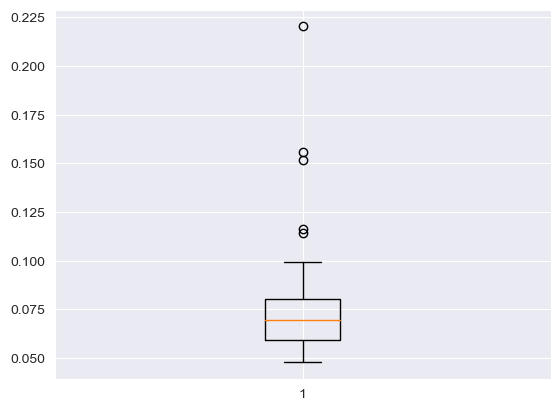

In [5]:
scale = np.empty(shape = len(CI_clusters))
for i,cluster in enumerate(CI_clusters):
    OC = star_cluster(cluster, CI_df)
    pca = PCA(n_components=2)
    pca_arr = pca.fit_transform(OC.CMD)
    X = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)
    scale[i] = 1 / (2* np.var(X))

f,ax = plt.subplots()
ax.boxplot(scale)

print("median:",np.median(scale),"mean:", np.mean(scale))

 ## PCA and CMD of sample cluster

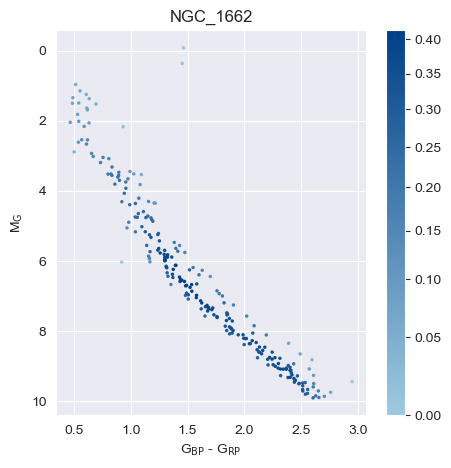

In [6]:
OC = star_cluster(CI_clusters[29], CI_df)
h = CMD_density_design([OC.CMD[:, 0], OC.CMD[:, 1]], title=OC.name)
pca = PCA(n_components=2)
pca_arr = pca.fit_transform(OC.CMD)


## PCA variation and parameter matrix

In [7]:
X = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)
y = pca_arr[:, 1]

evals = np.logspace(-4, 0, 5)
gvals = np.logspace(-4, 0, 5)
Cvals = np.logspace(-2, 2, 5)

svrs = []

for val in Cvals:
    svrs.append(SVR(kernel="rbf", C=val, gamma="scale", epsilon=0.1))
for val in gvals:
    svrs.append(SVR(kernel="rbf", C=1, gamma=val, epsilon=0.1))
for val in evals:
    svrs.append(SVR(kernel="rbf", C=1, gamma="scale", epsilon=val))

lw = 2

# kernel_label = ["C_0.01", "C_0.1", "C_1", "C_10", "C_100",
#                "gamma_0.0001", "gamma_0.001", "gamma_0.01", "gamma_0.1", "gamma_1",
#                "e_0.0001", "e_0.001", "e_0.01", "e_0.1", "e_1"]

model_color = ['#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824',
               '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000',
               #'#fa9fb5', '#f768a1', '#dd3497', '#ae017e', '#7a0177']
               '#9ebcda','#8c96c6','#8c6bb1','#88419d','#6e016b']

### PCA parameter matrix

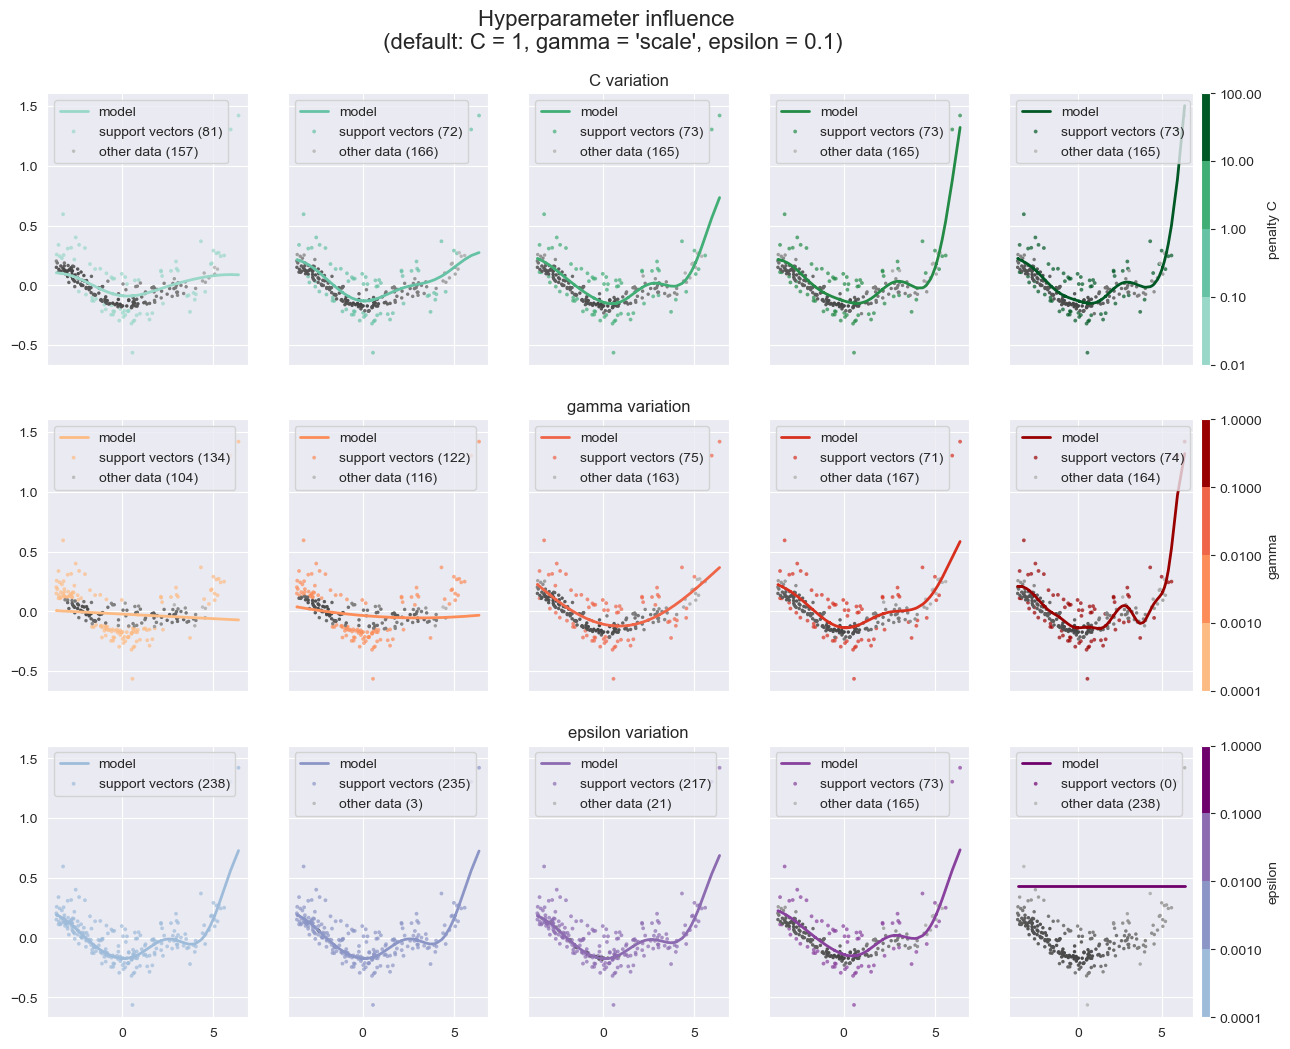

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 12), sharey=True, sharex=True)
axes = axes.ravel()

# model line
for ix, svr in enumerate(svrs):

    axes[ix].plot(
        X,
        svr.fit(X, y).predict(X),
        color=model_color[ix],
        lw=lw,
        label="model",
        # label="{} model".format(kernel_label[ix]),
    )

    otherX = X[np.setdiff1d(np.arange(len(X)), svr.support_)]
    otherY = y[np.setdiff1d(np.arange(len(X)), svr.support_)]
    if len(otherX)>0:
        PC_density_x, PC_density_y, PC_kwargs = CMD_density_design([otherX.reshape(len(otherX),), otherY.reshape(len(otherY),)], to_RBG=[0.27, 0.27, 0.27], from_RBG= [0.74,0.74,0.74], density_plot=False)


# support vector scatter
    axes[ix].scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor=model_color[ix],
        edgecolor="none",
        alpha=0.7, marker = ".",
        s=30,
        label="support vectors ({})".format(len(X[svr.support_]))
        # label="{} support vectors".format(kernel_label[ix]),
    )
# other datapoints scatter
    if len(otherX) >0:
        axes[ix].scatter(
            PC_density_x, PC_density_y,
            #X[np.setdiff1d(np.arange(len(X)), svr.support_)],
            #y[np.setdiff1d(np.arange(len(X)), svr.support_)],
            #facecolor="k",
            #edgecolor="none",
            #alpha=0.5, marker = ".",
            #s=50,
            label="other data ({})".format(int(len(X)-len(X[svr.support_]))), **PC_kwargs
        )
# legend
    axes[ix].legend(
        loc="upper left",
        # bbox_to_anchor=(0.5, 1.1),
        # ncol=1,
        # fancybox=True,
        # shadow=True,
    )

# Colorbars
cax_id = [4,9,14]
labels = ["penalty C", "gamma", "epsilon"]
hypers =[Cvals, gvals, evals]
c_ix = 0

for i,hyper in enumerate(hypers):
    divider = make_axes_locatable(axes[cax_id[i]])
    cax_fig = divider.append_axes('right', size='5%', pad=0.075)
    cmap = mpl.colors.ListedColormap(model_color[c_ix:c_ix+5])
    norm = mpl.colors.BoundaryNorm(hyper, cmap.N)
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
             cax=cax_fig,
             ticks=hyper,
             spacing='uniform',
             orientation='vertical',
             label= labels[i])
    c_ix += 5

axes[2].set_title("C variation")
axes[7].set_title("gamma variation")
axes[12].set_title("epsilon variation")
fig.suptitle("Hyperparameter influence \n (default: C = 1, gamma = 'scale', epsilon = 0.1)",y = 0.95, fontsize = 16)
fig.savefig(output_path + "{}_Hyperparam_matrix.pdf".format(OC.name), dpi=500)


### SVR reverse transform matrix

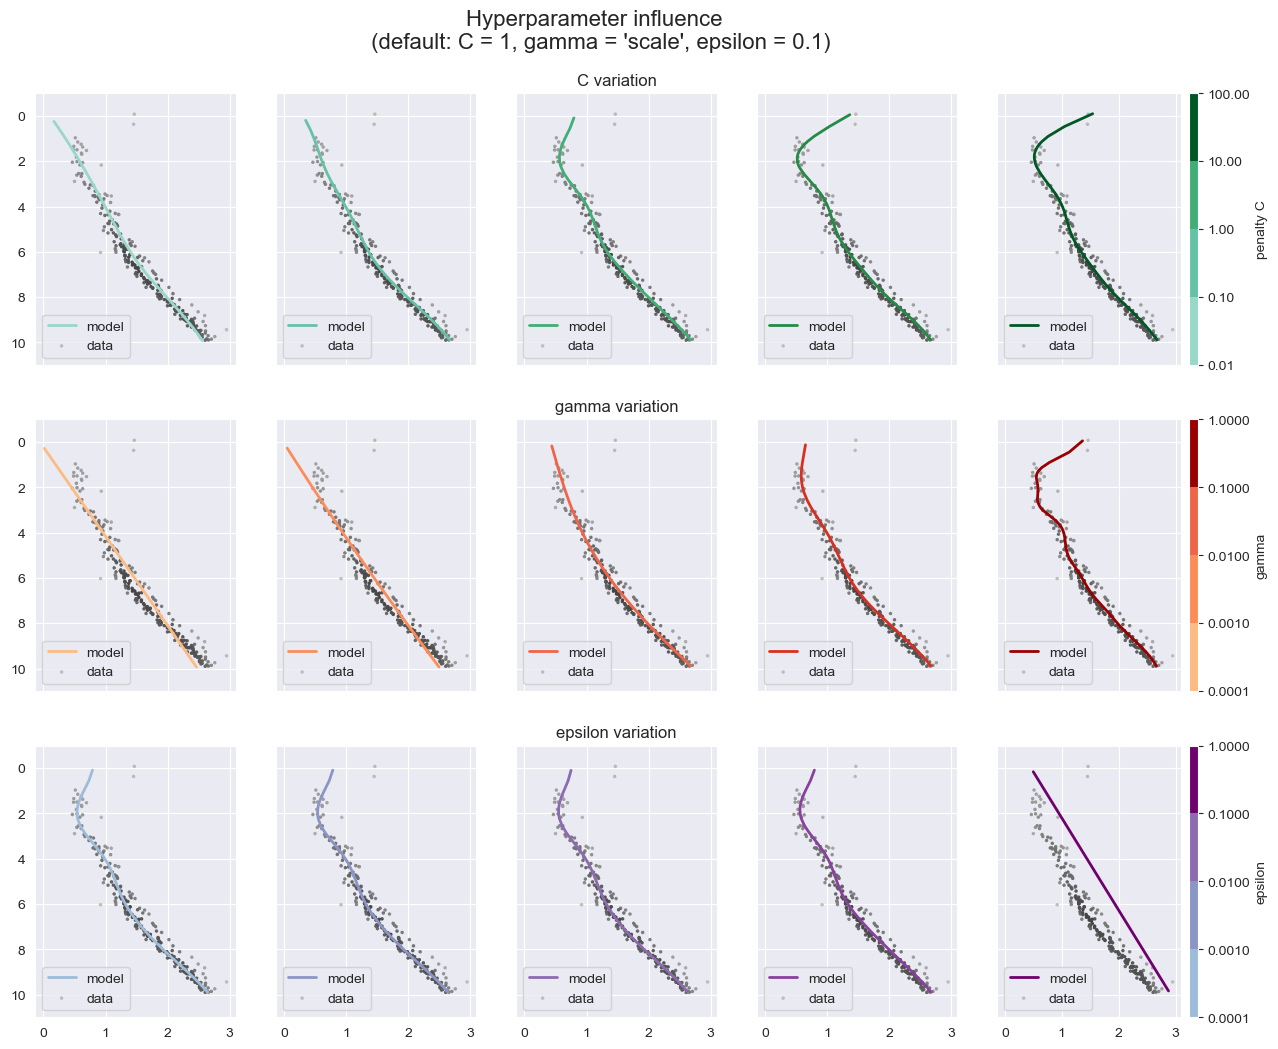

In [9]:
OC_density_x, OC_density_y, OC_kwargs = CMD_density_design([OC.CMD[:,0], OC.CMD[:,1]], to_RBG=[0.27, 0.27, 0.27], from_RBG= [0.74,0.74,0.74], density_plot=False)

fig_CMD, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 12), sharey=True, sharex=True)
axes = axes.ravel()

for ix, svr in enumerate(svrs):
    SVR_all = np.stack([X[:, 0], svr.fit(X, y).predict(X)], 1)
    SVR_all = SVR_all[SVR_all[:, 0].argsort()]
    rev_transform = pca.inverse_transform(SVR_all)

# model line
    axes[ix].plot(
        rev_transform[:, 0],
        rev_transform[:, 1],
        color=model_color[ix],
        lw=lw,
        label="model",
        # label="{} model".format(kernel_label[ix]),
    )
# other datapoints
    axes[ix].scatter(OC_density_x,
                     OC_density_y,
                     label="data", **OC_kwargs)
    axes[ix].set_ylim(11,-1)
# legend
    axes[ix].legend(
        loc="lower left",
        # bbox_to_anchor=(0.5, 1.1),
        # ncol=1,
        # fancybox=True,
    )

# Colorbars
cax_id = [4,9,14]
labels = ["penalty C", "gamma", "epsilon"]
hypers =[Cvals, gvals, evals]
c_ix = 0

for i,hyper in enumerate(hypers):
    divider = make_axes_locatable(axes[cax_id[i]])
    cax = divider.append_axes('right', size='5%', pad=0.075)
    cmap = mpl.colors.ListedColormap(model_color[c_ix:c_ix+5])
    norm = mpl.colors.BoundaryNorm(hyper, cmap.N)
    fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
             cax=cax,
             ticks=hyper,
             spacing='uniform',
             orientation='vertical',
             label= labels[i])
    c_ix += 5




axes[2].set_title("C variation")
axes[7].set_title("gamma variation")
axes[12].set_title("epsilon variation")
fig_CMD.suptitle("Hyperparameter influence \n (default: C = 1, gamma = 'scale', epsilon = 0.1)",y = 0.95, fontsize=16)
fig_CMD.savefig(output_path + "{}_Hyperparam_matrix_CMD.pdf".format(OC.name), dpi=500)

## Direct comparison between default hyperparameters and tuned result
### Addition: Using different gridsearch methods (second block)

In [10]:




OC = star_cluster(CI_clusters[29], CI_df)
pca = PCA(n_components=2)
pca_arr = pca.fit_transform(OC.CMD)
params = SVR_Hyperparameter_tuning(pca_arr, param_grid)

X = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)
y = pca_arr[:, 1]

fin
{'C': 100.0, 'epsilon': 0.017252105499420408, 'gamma': 'scale', 'kernel': 'rbf'}
score: 0.604201035230022
std: 0.1735972502396


In [11]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

fine_grid = dict(kernel=['rbf'], C=np.linspace(10,100,15), gamma=["scale"],epsilon= np.linspace(0.1*params["epsilon"], 5*params["epsilon"], 15))
base_estimator = SVR()


sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                         factor=3).fit(X, y)
fine_params =sh.best_params_
print(fine_params)
print(sh.best_score_)

/Users/alena/.conda/envs/PaperI/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/alena/.conda/envs/PaperI/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/alena/.conda/envs/PaperI/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/alena/.conda/envs/PaperI/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/Users/alena/.conda/envs/PaperI/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: Undefin

{'C': 0.7847599703514611, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}
0.04124039065178973


/Users/alena/.conda/envs/PaperI/lib/python3.10/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan           

In [12]:
from skopt import BayesSearchCV

opt = BayesSearchCV(
    base_estimator,param_grid,
    cv=5)

opt.fit(X, y)

print("val. score: %s" % opt.best_score_)
print("best params: %s" % str(opt.best_params_))
bayes_params = opt.best_params_

/Users/alena/.conda/envs/PaperI/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


val. score: 0.06515272273462783
best params: OrderedDict([('C', 1.2742749857031335), ('epsilon', 0.026366508987303583), ('gamma', 'scale'), ('kernel', 'rbf')])


### Illustration of the results

SVR Test score: 1.0
SVR Test score: 1.0
SVR Test score: 1.0
SVR Test score: 1.0


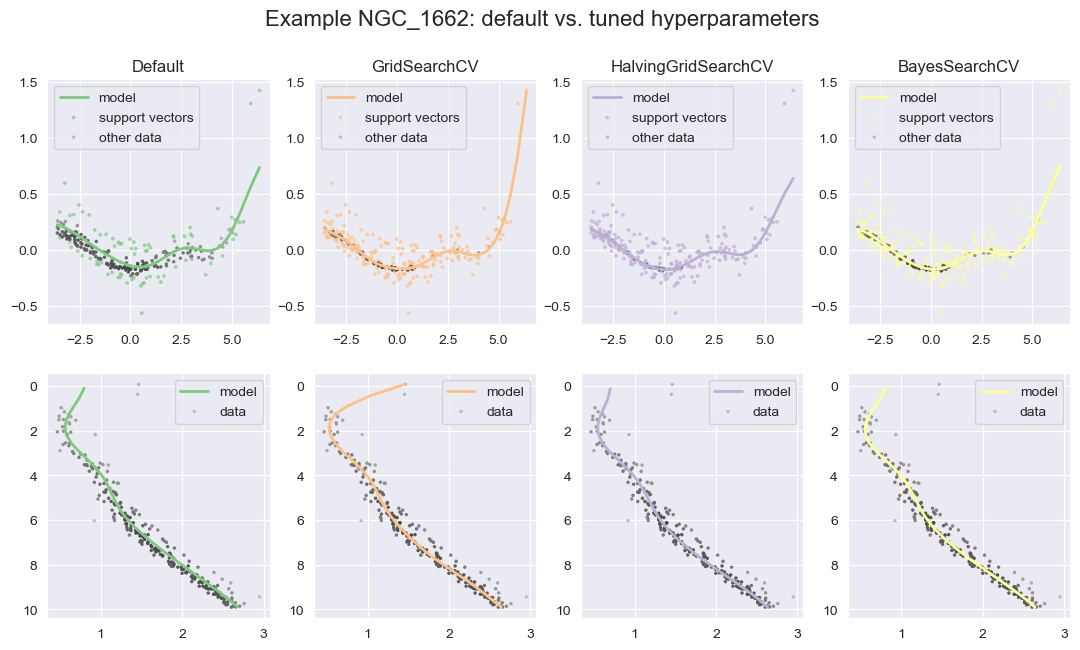

In [13]:
svr_tuned = SVR(**params)
svr_untuned = SVR()
svr_finetuned = SVR(**fine_params)
svr_bayes = SVR(**bayes_params)

svrs_new = [svr_untuned,svr_tuned, svr_finetuned, svr_bayes]
colors = ["#7fc97f", "#fdc086", "#beaed4", "#ffff99"]

X = pca_arr[:, 0].reshape(len(pca_arr[:, 0]), 1)
y = pca_arr[:, 1]



fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(11,7))

plt.subplots_adjust(left=0.05, right = 0.98, hspace = 0.2, wspace=0.2)
axes = axes.ravel()

# model line
for ix, svr in enumerate(svrs_new):
    print("SVR Test score:", svr.score(X, svr.fit(X, y).predict(X)))
    SVR_all = np.stack([X[:, 0], svr.fit(X, y).predict(X)], 1)
    SVR_all = SVR_all[SVR_all[:, 0].argsort()]
    rev_transform = pca.inverse_transform(SVR_all)

# first row
# model line
    axes[ix].plot(
        X,
        svr.fit(X, y).predict(X),
        color=colors[ix],
        lw=lw,
        label="model",
    )
# support vector scatter
    axes[ix].scatter(
        X[svr.support_],
        y[svr.support_],
        facecolor=colors[ix],
        edgecolor="none",
        alpha=0.7, marker = ".",
        s=30,
        label="support vectors"
    )
# other datapoints scatter

    otherX = X[np.setdiff1d(np.arange(len(X)), svr.support_)]
    otherY = y[np.setdiff1d(np.arange(len(X)), svr.support_)]
    if len(otherX)>0:
            PC_density_x, PC_density_y, PC_kwargs = CMD_density_design([otherX.reshape(len(otherX),), otherY.reshape(len(otherY),)], to_RBG=[0.27, 0.27, 0.27], from_RBG= [0.74,0.74,0.74], density_plot=False)


    axes[ix].scatter(
        PC_density_x, PC_density_y,
        #X[np.setdiff1d(np.arange(len(X)), svr.support_)],
        #y[np.setdiff1d(np.arange(len(X)), svr.support_)],
        #facecolor="k",
        #edgecolor="none",
        #alpha=0.5, marker = ".",
        #s=50,
        label="other data", **PC_kwargs)
# legend
    ymin,ymax = axes[ix].get_ylim()
    axes[ix].set_ylim(ymin,ymax)
    axes[ix].legend(
        loc="upper left",
    )

# Second row
# model line
    axes[ix+4].plot(
        rev_transform[:, 0],
        rev_transform[:, 1],
        color=colors[ix],
        lw=lw,
        label="model",
        # label="{} model".format(kernel_label[ix]),
    )
# other datapoints
    axes[ix+4].scatter(OC_density_x,
                     OC_density_y,
                     label="data", **OC_kwargs)
# legend
    ymin2,ymax2 = axes[ix+4].get_ylim()
    axes[ix+4].set_ylim(ymax2,ymin2)
    axes[ix+4].legend(
        loc="upper right",
    )

axes[0].set_title("Default") #\n (C=1, gamma = 'scale', epsilon = 0.1)")
axes[1].set_title("GridSearchCV")# \n (C=100, gamma = 0.1, epsilon = 0.01)")
axes[2].set_title("HalvingGridSearchCV")# \n (C=10, gamma = 0.05, epsilon = 0.0114)")
axes[3].set_title("BayesSearchCV")# \n (C=10, gamma = 0.05, epsilon = 0.0114)")
plt.suptitle("Example {}: default vs. tuned hyperparameters".format(OC.name), fontsize =16)

fig.savefig(output_path+"{}_different_Gridsearches.pdf".format(OC.name), dpi = 500)